<a href="https://colab.research.google.com/github/sohyeon98720/deepLearning_GAN/blob/master/keras_gan_with_vein_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 버전 다운그레이드.안하면 뒤에서 오류남.
pip install --upgrade tensorflow==1.14

     |████████████████████████████████| 109.2MB 29kB/s 
     |████████████████████████████████| 3.2MB 45.7MB/s 
     |████████████████████████████████| 491kB 40.6MB/s 
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1


In [ ]:
# 필요한 모듈 임포트 및 설정

import argparse
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K

K.set_image_data_format('channels_first')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [ ]:
# 버전 확인하기
print(keras.__version__)
print(tf.__version__)

2.2.5
1.14.0


## Define Dataset

In [ ]:
# 구글드라이브 마운트 -> 링크들어가서 코드복사하여 붙여넣기
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# 파일 확인 -> 너무 많아 생략함
# !dir '/gdrive/My Drive/FVR_DB_NEW_SEG'

FVR_DB_NEW_SEG.zip    [SEG]김유미_3_5.bmp   [SEG]김유미_7_1.bmp
[SEG]이지우_1_10.bmp  [SEG]김주리_3_5.bmp   [SEG]김주리_7_1.bmp
[SEG]조철우_1_10.bmp  [SEG]이현창_3_5.bmp   [SEG]이종일_7_1.bmp
[SEG]허환이_1_10.bmp  [SEG]전태산_3_5.bmp   [SEG]이현창_7_1.bmp
[SEG]이시몽_1_10.bmp  [SEG]정대식_3_5.bmp   [SEG]전태산_7_1.bmp
[SEG]이원오_1_10.bmp  [SEG]조황원_3_5.bmp   [SEG]정대식_7_1.bmp
[SEG]이재현_1_10.bmp  [SEG]최현동_3_5.bmp   [SEG]조황원_7_1.bmp
[SEG]이정주_1_10.bmp  [SEG]현교환_3_5.bmp   [SEG]최현동_7_1.bmp
[SEG]고유진_1_10.bmp  [SEG]남현하_3_5.bmp   [SEG]현교환_7_1.bmp
[SEG]김보나_1_10.bmp  [SEG]박선호_3_5.bmp   [SEG]남현하_7_1.bmp
[SEG]김유미_1_10.bmp  [SEG]박영호_3_5.bmp   [SEG]박선호_7_1.bmp
[SEG]김주리_1_10.bmp  [SEG]박천우_3_5.bmp   [SEG]박영호_7_1.bmp
[SEG]남기표_1_10.bmp  [SEG]윤기훈_3_5.bmp   [SEG]박천우_7_1.bmp
[SEG]이현창_1_10.bmp  [SEG]김민호_3_5.bmp   [SEG]윤기훈_7_1.bmp
[SEG]전태산_1_10.bmp  [SEG]김지현_3

In [ ]:
# 1. 경로내의 모든 파일 불러오기 -> 리스트에 경로저장됨
# 2. 원래 모든 파일인데 2610장이 너무 학습하는데에 오래걸려서 일시적으로 각 사람의 손가락의 첫번째 사진만 불러옴
# 3. 줄인 사진이 248개인데 이거도 많아서 더 줄임(각 사람의 첫번째 손가락의 첫번째 사진만)
import glob
import matplotlib.pyplot as plt
data_all=[]
files = glob.glob('/gdrive/My Drive/FVR_DB_NEW_SEG/*_1_1.bmp')
for file in files:
  data_all.append(file)

(60, 152)
(1, 60, 152)


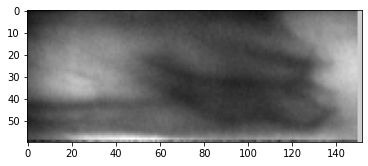

In [ ]:
# 테스트용 : 리스트의 경로를 이미지로 변환하는 과정
import matplotlib.pyplot as plt
import numpy as np
sss=[]
image1=plt.imread(data_all[0])
print(image1.shape)
plt.imshow(image1,cmap='gray')
sss.append(image1)
x = np.array(sss)
print(x.shape)

In [ ]:
# 리스트 내의 경로를 모두 이미지로 변환하여 저장 -> 시간 조금 걸림
import matplotlib.pyplot as plt
import numpy as np
sss=[]
for i in range(len(data_all)):
  image=plt.imread(data_all[i])
  sss.append(image)
x=np.array(sss)

In [ ]:
# 데이터의 shape 확인
# 첫번째 인자가 데이터의 갯수
# 원래 2610에서 248로 줄음
# 248에서 32로 줄음
print(x.shape)

(32, 60, 152)


In [ ]:
# 테스트용 : Data클래스의 __init__함수부분. 코드의 의미 확인하기 위해 실행함.
X_train=x
x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)
x_data = x_data.reshape((x_data.shape[0], 1) + x_data.shape[1:])

In [ ]:
# 테스트용 : Data클래스의 __init__함수부분. 코드의 의미 확인하기 위해 실행함.
print(x_data.shape)

(248, 1, 60, 152)


In [ ]:
# 테스트용 : Data클래스의 __init__함수부분. 코드의 의미 확인하기 위해 실행함.
print(x_data.ndim)

4


In [ ]:
# 테스트용 : Data클래스의 get_z_sample함수부분. 코드의 의미 확인하기 위해 실행함.
sample_size=2
z_input_dim=10
# -> (2,10) 크기이고 범위가 -1에서 1인 난수 생성해라
aa=np.random.uniform(-1.0, 1.0, (sample_size, z_input_dim))

In [ ]:
# 테스트용 : Data클래스의 get_z_sample함수부분. 코드의 의미 확인하기 위해 실행함.
print(aa.shape)
print(aa.ndim)
print(aa)

(2, 10)
2
[[-0.90551444  0.7291676  -0.88196549  0.06572408 -0.34057756  0.20318816
  -0.44656726  0.10274207 -0.70232142  0.97227815]
 [-0.44886726  0.36125655 -0.0275779   0.25428946 -0.96249847  0.88698694
   0.3488633   0.5581565   0.01954347  0.30590965]]


In [ ]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        X_train=x
        # 밑의 코드는 4차원으로 바꿔주는 역할임
        self.x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        # 무작위 샘플 반환(0부터 데이터의 총 갯수 중 batch_size개를 랜덤 반환 -> x_data의 인덱스가 됨)
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        # -> (sample_size,z_input_dim) 크기이고 범위가 -1에서 1인 난수 생성해라
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))

- Mnist data test

In [ ]:
# 함수가 잘 실행되나 확인
data = Data(batch_size=2, z_input_dim=10)
print(data.get_real_sample())
print(data.get_z_sample(2))

[[[[-0.8980392  -0.8509804  -0.8901961  ... -0.73333335  0.60784316
     0.60784316]
   [-0.8039216  -0.79607844 -0.7882353  ... -0.5686275   0.60784316
     0.60784316]
   [-0.79607844 -0.7882353  -0.77254903 ... -0.58431375  0.60784316
     0.60784316]
   ...
   [ 0.5058824   0.5137255   0.4509804  ...  0.35686275  0.60784316
     0.60784316]
   [ 0.41960785  0.43529412  0.42745098 ...  0.48235294  0.60784316
     0.60784316]
   [ 0.03529412  0.03529412 -0.01176471 ... -0.16078432  0.60784316
     0.60784316]]]


 [[[-0.9529412  -0.94509804 -0.92941177 ... -0.37254903  0.60784316
     0.60784316]
   [-0.96862745 -0.9372549  -0.90588236 ... -0.31764707  0.60784316
     0.60784316]
   [-0.96862745 -0.96862745 -0.94509804 ... -0.37254903  0.60784316
     0.60784316]
   ...
   [-0.99215686 -0.9764706  -0.9529412  ... -0.4509804   0.60784316
     0.60784316]
   [-1.         -0.9843137  -0.96862745 ... -0.5294118   0.60784316
     0.60784316]
   [-1.         -1.         -1.         ... -0.

## GAN 모델 정의

- discriminator : CNN 판별기로 모델링
- generator : input Z를 확장한 뒤 CNN 생성기로 모델링

In [ ]:
# generator는 cnn(discriminator)의 반대 역할을 하는 구조가 보인다.
# 이미지의 해상도는 점점 올라가고, 깊이(채널?)는 점점 작아진다. discriminator를 뒤집어 놓은듯한 구조이면서도 차이점이 있다.

# 원래 DCGAN은 fractionally-strided convolution을 사용하는 것으로 제안되었는데, upsampling이라는 기법을 사용했다고 한다 -> 더 좋은 결과를 바랄 수 있음

class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1, 60, 152),
                     #정규분포를 가진 임의 가중치 초기화(stddev는 표준편차)
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))
        # output : 진짜 / 가짜 : 1 (sigmoid를 통해 0.5 기준으로 classification)
        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        """
        define generator
        """

        G = Sequential()
        #512는 출력뉴런의 수, input_dim은 입력뉴런의 수
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 15 * 38))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        # reshape하면 output shape 형태 (batch_size,) + target_shape
        G.add(Reshape((128, 15, 38), input_shape=(128 * 15 * 38,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        defien combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD


## Learner 구성

- discriminator와 generator를 다른 epoch 비율로 학습 가능하도록 구성
- 20 epoch 마다 이미지 생성
- D, G를 각각 학습
- 학습 완료 후 loss graph 생성

In [ ]:
# 테스트용: Model클래스의 train_D함수부분. 코드의 의미 확인하기 위해 실행함.
a = np.array([[1, 2], [3, 4]])
b = np.array([[7, 8], [9, 10], [11, 12]])

print(a.shape)
print(b.shape)

# print(np.concatenate((a, b), axis=None))
# print(np.concatenate((a, b), axis=None).shape)

print(np.concatenate((a, b), axis=0))

(2, 2)
(3, 2)
[[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]
 [11 12]]


In [ ]:
# GAN의 두 개의 네트워크를 트레이닝 하다 보면 다음과 같은 문제가 생길 수 있다.
# discriminator가 너무 뛰어나면 0이나 1에 매우 가까운 gradient값을 반환하게 되어, generator가 gradient값을 제대로 반영하기 어렵게 된다.
# generator가 너무 뛰어나면 discriminator가 진짜 데이터를 가짜 데이터로 판단할 확률이 높아진다. 이러한 문제는 두 신경망의 학습률(learning rates)을 각각 설정하여 완화할 수 있다.
#두 개의 신경망은 항상 비슷한 “학습 수준”을 유지해야 한다.

class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 20 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=8)
                print('Epoch:', str(epoch))
                print('Discriminator loss:', str(dloss))
                print('Generator loss:', str(gloss))
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)

        # labeling and concat generated, real images
        x = np.concatenate((real, generated_images), axis=0)
        y = [0.9] * self.batch_size + [0] * self.batch_size

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((60, 152)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()


## 학습 진행







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epochs: 1000
Batch size: 128
Batches per epoch: 0.25
Learning rate: 0.0002
Image data format: channels_first


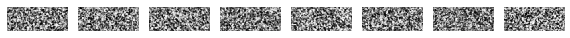

Epoch: 0
Discriminator loss: [0.68234456, 0.01171875]
Generator loss: [1.1920932e-07, 1.0]


In [ ]:
def main():
    # set hyper parameters    
    batch_size = 128
    epochs = 1000
    learning_rate = 0.0002
    z_input_dim = 100
    n_iter_D = 1
    n_iter_G = 5

    # run model
    model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)
    model.fit()


if __name__ == '__main__':
    main()